In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from piaxi_numerics import set_params, solve_system, get_text_params

In [2]:
# Set constants of model
e    = 0.3      # dimensionless electron charge
F    = 1e11    # pi-axion decay constant (GeV)
#F = 1
p_t  = 0.4      # total local DM density (GeV/cm^3)
## --> TODO: is the DM density energy density unitful/correct as above?

## Tuneable constants
# millicharge, vary to enable/disable charged species (10e-15 = OFF, 10e-25 = ON)
#eps  = 1e-25   # (unitless)
eps  = 1

# Coupling constants
L3   = 1e11    # (GeV)
#L3 = 1
L4   = 1e11    # (GeV)
#L4 = 1
l1   = 1       #
l2   = 1       #
l3   = 1       #
l4   = 1       #

# Unit scaling:
GeV  = 1e9     # GeV -> eV
#GeV = 1
F   *= GeV
p_t *= GeV
L3  *= GeV
L4  *= GeV

In [3]:
# Initial Conditions
A_0    = 0.1
Adot_0 = 0.0
A_pm   = +1       # specify A± case (+1 or -1)
A_sens = 1.0      # sensitivity for classification of resonance conditions

In [4]:
# Time domain
t_span = [0, 30]   # TODO: replace with the appropriate values
t_N    = 300       # Number of timesteps
t_sens = 0.1       # sensitivity for calculating time-averaged values

# k values
use_k0 = False     # Toggle whether or not k = 0 is included in the numerics (div. by 0 if on)
k_min = 0 if use_k0 else 1
k_span = [k_min, 200]  # TODO: replace with the appropriate values
k_N = (201 - k_min)    # Number of k-modes

In [5]:
# Parameters of model

# masses for real, complex, and charged species in range (10e-8, 10e-4)
#m_scale = 1e-8              # eV
m_scale = 1
m = m_scale * np.array([1., 3., 5.])

# local DM densities/amplitudes for each species
p    = np.array([1/3., 1/3., 1/3.]) * p_t
amps = np.array([np.sqrt(2. * p[i]) / m[i] for i in range(len(m))])
# normalize amplitudes by dividing by amp of pi_0
#amps / amps[0]

# local phases for each species (to be sampled)
d    = [0, 0, 0]   # (0, 2pi)
d_sample = True

# global phase for neutral complex species (to be sampled)
Th   = [0, 0, 0]   # (0, 2pi)
Th_sample = True

In [6]:
# Sample phases from normal distribution, between 0 and 2pi
mu  = np.pi      # mean
sig = np.pi / 3  # standard deviation

# Modulo 2pi to ensure value is within range
if d_sample:
        d = [np.mod(np.random.normal(mu, sig), 2*np.pi) for d_i in d]
if Th_sample:
        Th = [np.mod(np.random.normal(mu, sig), 2*np.pi) for Th_i in Th]

In [7]:
## Define the system of ODEs
# TODO: Finish defining time-dependent functions P(t), B(t), C(t), D(t) here
#       - Verify they are the correct form, double check all signs and factors of 2
# NOTE: Using cosine definitons for amplitudes
#       i = {0,1,2} correspond to {pi_0, pi, pi_+/-} respectively

phi = lambda t, i, m=m, d=d, M=m_scale: (m[i]/M)*t + d[i]

# Define helper functions to clean up differential equation
P = lambda t, l3=l3, L3=L3, l4=l4, L4=L4, eps=eps, amps=amps, m=m, d=d, Th=Th, phi=phi, np=np: \
            4*l3/(L3**2) * eps**2 * (np.abs(amps[2])**2 * np.cos(phi(t,2))**2) + \
            4*l4/(L4**2) * eps**2 * (np.abs(amps[1])**2 * np.cos(phi(t,1))**2 + \
                                     np.abs(amps[0])**2 * np.cos(phi(t,0))**2 + \
                                     2*np.abs(amps[0])*np.abs(amps[1]) * np.cos(phi(t,0))*np.cos(phi(t,1)) * np.cos(Th[1]))

B = lambda t, l3=l3, L3=L3, l4=l4, L4=L4, eps=eps, amps=amps, m=m, d=d, Th=Th, phi=phi, np=np: \
            (-1)*8*l3/(L3**2) * eps**2 * (np.abs(amps[2])**2 * m[2] * np.sin(phi(t,2)) * np.cos(phi(t,2))) + \
            (+1)*8*l4/(L4**2) * eps**2 * (np.abs(amps[0])**2 * m[0] * np.sin(phi(t,0)) * np.cos(phi(t,0)) + \
                                          np.abs(amps[1])**2 * m[1] * np.sin(phi(t,1)) * np.cos(phi(t,1)) + \
                                          np.abs(amps[1])*np.abs(amps[0]) * np.cos(Th[1]) * \
                                              (m[0] * np.sin(phi(t,0)) * np.cos(phi(t,1)) + \
                                               m[1] * np.sin(phi(t,1)) * np.cos(phi(t,0))))

C = lambda t, pm, l1=l1, F=F, eps=eps, amps=amps, m=m, d=d, phi=phi, np=np: \
            (-1) * pm * (2*l1 / F * eps**2) * np.abs(amps[0]) * m[0] * np.sin(phi(t,0))

D = lambda t, l2=l2, e=e, eps=eps, amps=amps, m=m, d=d, phi=phi, np=np: \
            2*l2 * eps**2 * e**2 * np.abs(amps[2])**2 * np.cos(phi(t,2))**2

def local_system(t, y, k, params, P=P, B=B, C=C, D=D, A_pm=A_pm, bg=1):
    # System of differential equations to be solved
    dy0dt = y[1]
    dy1dt = -1/(bg + P(t)) * (B(t)*y[1] + (C(t, A_pm)*k + D(t))*y[0]) - k**2*y[0]
    return [dy0dt, dy1dt]

In [8]:
# Solve the differential equation for each k

k_values, k_step = np.linspace(k_span[0], k_span[1], k_N, retstep=True)
#k_values = np.linspace(1./100, 10, 100)

# Initialize an array to store the solutions
t, t_step = np.linspace(t_span[0], t_span[1], t_N, retstep=True)  # Array of times at which to evaluate, t > 0
#t = t[1:]

# Classification sensitivity threshold
res_con = 10000
#res_con = max(100,1./A_sens)

# Set all parameters on the backend
parameters = {"e": e, "F": F, "p_t": p_t, "eps": eps, "L3": L3, "L4": L4, "l1": l1, "l2": l2, "l3": l3, "l4": l4, "res_con": res_con,
              "A_0": A_0, "Adot_0": Adot_0, "A_pm": A_pm, "m": m, "p": p, "amps": amps, "d": d, "Th": Th, 
              "t_sens": t_sens, "A_sens": A_sens}
params = set_params(parameters, t_min=t_span[0], t_max=t_span[1], t_N=t_N, k_min=k_span[0], k_max=k_span[1], k_N=k_N)

# Solve the system, in parallel
solutions, params, time_elapsed, timestr = solve_system(local_system, jupyter=True, parallelize=True, num_cores=32)
print(timestr)

0:06:07.007885 on 32 cores


max (peak) k mode: 48.0
max (mean) k mode: 48.0


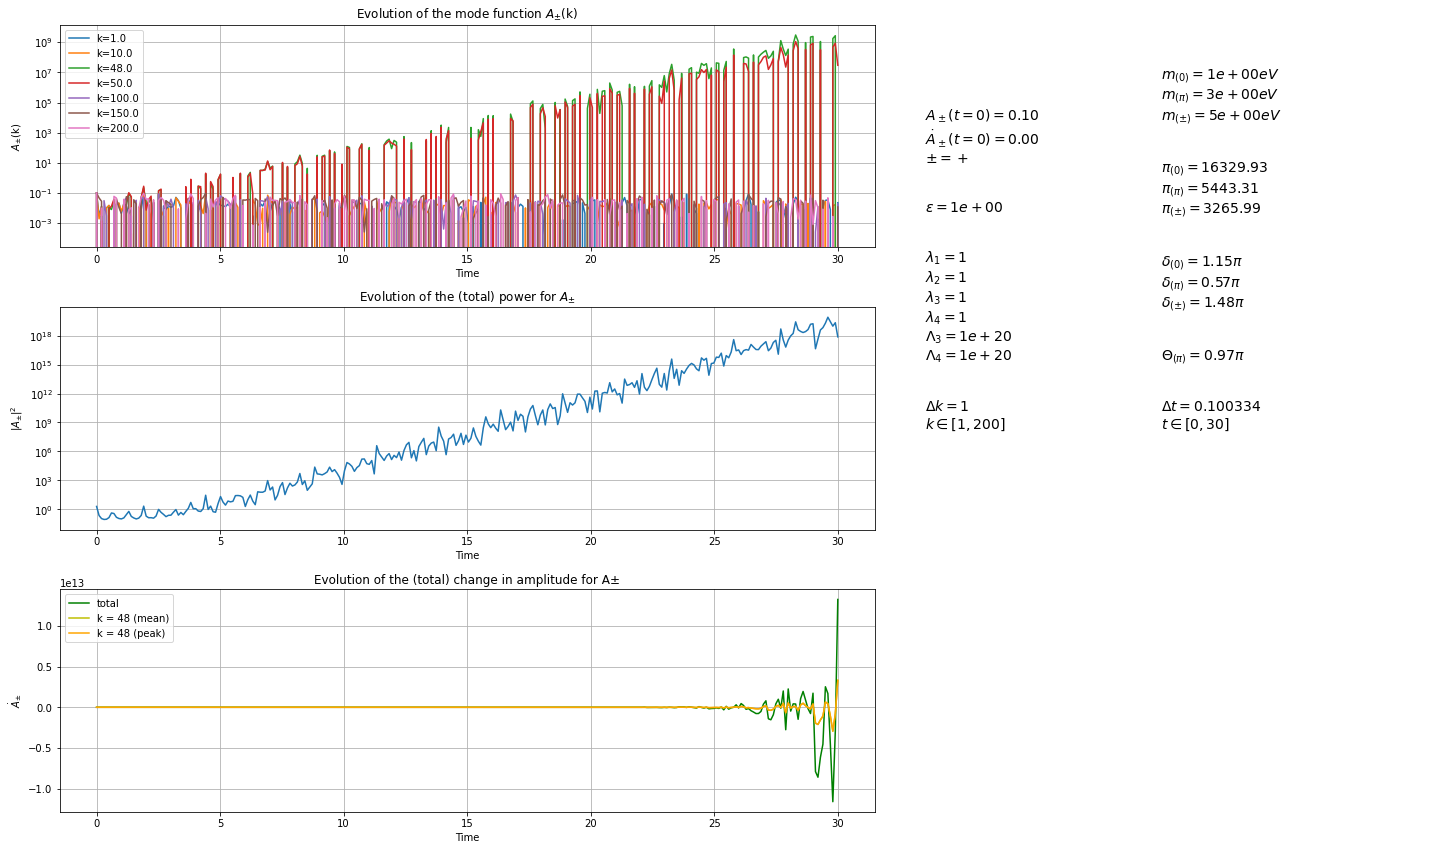

In [9]:
## Identify the k mode with the greatest peak amplitude, and the mode with the greatest average amplitude
# k_func : apply [func] on the time-series for each k mode, e.g. max or mean
k_func = lambda func: np.array([k_fval for k_fi, k_fval in enumerate([func(np.abs(solutions[k_vi][0][:])) for k_vi, k_v in enumerate(k_values)])])
# k_sens : apply [k_func] but limit the time-series by [sens], e.g. sens = 0.1 to look at the first 10%. Negative values look at the end of the array instead.
w_min  = lambda sens: int(t_N*(1./2)*np.abs(((1. - sens)*np.sign(sens) + (1. - sens))))  # min value / left endpoint (of the sensitivity window over which to average)
w_max  = lambda sens: int(t_N*(1./2)*np.abs(((1. + sens)*np.sign(sens) + (1. - sens))))  # max value / right endpoint
k_sens = lambda func, sens: np.array([k_fval for k_fi, k_fval in enumerate([func(np.abs(solutions[k_vi][0][w_min(sens):w_max(sens)])) for k_vi, k_v in enumerate(k_values)])])
#k_sens = lambda func, sens: np.array([k_fval for k_fi, k_fval in enumerate([func(np.abs(solutions[k_vi][0][int(t_span[1]*(1. - sens)):])) for k_vi, k_v in enumerate(k_values)])])
# k_ratio: apply [k_func] to each k mode and then return the ratio of the final vs. initial ampltidues (sensitive to a windowed average specified by [sens])
k_ratio = lambda func, t_sens, A_sens: np.array([k_f/k_i for k_f, k_i in zip(k_sens(func, t_sens), k_sens(func, -t_sens))])
# k_class: softly classify the level of resonance according to the final/initial mode amplitude ratio, governed by [func, t_sens, and A_sens]
k_class = lambda func, t_sens, A_sens: np.array(["damp" if k_r <= 0.9 else "none" if k_r <= (1. + np.abs(A_sens)) else "semi" if k_r <= res_con else "res" for k_r in k_ratio(func, t_sens, A_sens)])

# k mode(s) with the largest contributions to overall number density growth
k_peak = k_values[np.argmax(k_func(max))]
k_mean = k_values[np.argmax(k_func(np.mean))]

print("max (peak) k mode: "+str(k_peak))
print("max (mean) k mode: "+str(k_mean))

# Plot the solution
signstr = {1: "+", -1: "-", 0: "±"}
#k_samples = np.geomspace(1,len(k_values),num=5)
k_samples = [i for i, k_i in enumerate(k_values) if k_i in [0,1,10,50,100,150,200,k_peak,k_mean]]
times = t
plot_Adot = True

xdim = 5
if plot_Adot:
    ydim = 3 
else:
    ydim = 2

plt.figure(figsize=(4*xdim, 4*ydim))

#plt.subplot(2,1,1)
plt.subplot2grid((ydim,xdim), (0,0), colspan=3)
for k_sample in k_samples:
    k_s = int(k_sample)
    #print(solutions[k_s, 0])
    plt.plot(times, solutions[k_s][0], label='k='+str(k_values[k_s]))
plt.title('Evolution of the mode function $A_{'+signstr[0]+'}$(k)')
plt.xlabel('Time')
plt.ylabel('$A_{'+signstr[0]+'}$(k)')
plt.yscale('log')
plt.legend()
plt.grid()

#plt.subplot(2,1,2)
plt.subplot2grid((ydim,xdim), (1,0), colspan=3)
plt.plot(times, [sum([np.abs(solutions[i][0][t_i])**2 for i in range(len(k_values))]) for t_i in range(len(times))])
plt.title('Evolution of the (total) power for $A_{'+signstr[0]+'}$')
plt.xlabel('Time')
plt.ylabel('$|A_{'+signstr[0]+'}|^2$')
plt.yscale('log')
plt.grid()


if plot_Adot:
    #plt.subplot(2,1,2)
    plt.subplot2grid((ydim,xdim), (2,0), colspan=3)
    plt.plot(times, [sum([solutions[i][1][t_i] for i in range(len(k_values))]) for t_i in range(len(times))], color='g', label='total')
    plt.plot(times, [solutions[list(k_values).index(k_mean)][1][t_i] for t_i in range(len(times))], color='y', label='k = %d (mean)' % k_mean)
    plt.plot(times, [solutions[list(k_values).index(k_peak)][1][t_i] for t_i in range(len(times))], color='orange', label='k = %d (peak)' % k_peak)
    plt.title('Evolution of the (total) change in amplitude for A'+signstr[0])
    plt.xlabel('Time')
    plt.ylabel('$\dot{A}_{'+signstr[0]+'}$')
    #plt.yscale('log')
    plt.legend()
    plt.grid()

textstr1, textstr2 = get_text_params(case='simple')

plt.subplot2grid((ydim,xdim), (max(0,ydim-3),3), rowspan=2)
plt.text(0.15, 0.2, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((ydim,xdim), (max(0,ydim-3),4), rowspan=2)
plt.text(0, 0.2, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

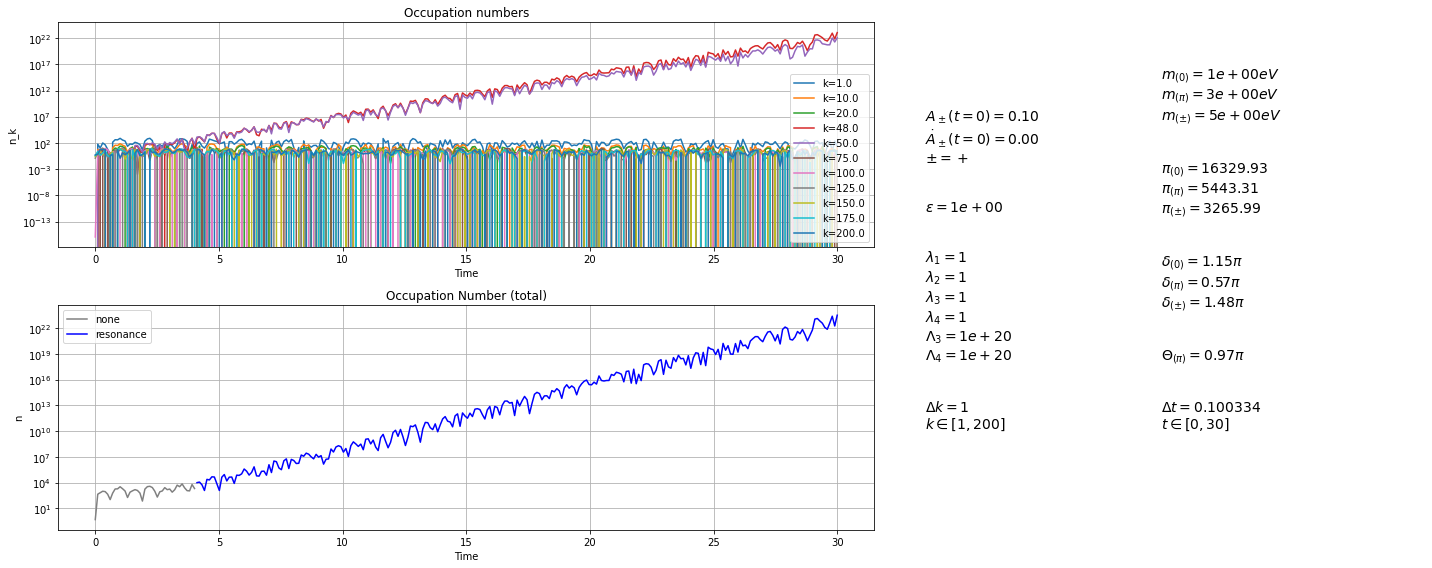

n_tot in range [5.00e-01, 3.34e+23]
resonance classification begins at t = 4.11, n = 10171.81


In [10]:
# Plot the occupation numbers
w = lambda i: np.abs(k_values[i])
n = lambda i: (w(i)/2) * (((np.square(np.abs(solutions[i][1])))/(np.square(w(i)))) + np.square(np.abs(solutions[i][0]))) - (1/2)
times = t
scale_n = False

#k_samples = np.geomspace(1,len(k_values),num=5)
k_samples = [i for i, k_i in enumerate(k_values) if k_i in [0,1,10,20,50,75,100,125,150,175,200,k_peak,k_mean]]
plt.figure(figsize=(20, 8))

plt.subplot2grid((2,5), (0,0), colspan=3)
for k_sample in k_samples:
    k_s = int(k_sample)
    plt.plot(times, n(k_s), label='k='+str(k_values[k_s]))
plt.title('Occupation numbers')
plt.xlabel('Time')
#plt.xlim(0,0.2)
plt.ylabel('n_k')
plt.yscale('log'); #plt.ylim(bottom = 0.1)
plt.legend()
plt.grid()

n_tot = np.array([sum([n(i)[t_i] for i in range(len(k_values))]) for t_i in range(len(times))])
if scale_n:
    n_tot /= abs(min(n_tot))
    n_tot += 1

#tot_res = 'resonance' if n_tot[-1]/n_tot[0] > 100 else 'none'
tot_res = 'resonance' if sum(k_ratio(np.mean, t_sens, A_sens)) > res_con else 'none'
t_res_i = np.argmax(np.array(n_tot) > res_con)
t_res   = t[t_res_i]
n_res   = n_tot[t_res_i]
parameters['res_class'] = tot_res
parameters['t_res'] = t_res
#n_res = res_con*sum(k_sens(np.mean, -t_sens))

#with plt.xkcd():
plt.subplot2grid((2,5), (1,0), colspan=3)
#fig,ax = plt.subplots()
#plt.plot(np.ma.masked_where(t >= t_res, times), np.ma.masked_where(np.array(n_tot) > res_con*sum(k_sens(np.mean, -t_sens)), n_tot), label='none', color='grey')
plt.plot(np.ma.masked_greater_equal(times, t_res), n_tot, label='none', color='grey')
plt.plot(np.ma.masked_less(times, t_res), n_tot, label='resonance', color='blue')
plt.title('Occupation Number (total)')
plt.xlabel('Time')
#plt.xlim(0,0.1)
plt.ylabel('n')
plt.yscale('log')
plt.legend()
plt.grid()

textstr1, textstr2 = get_text_params(case='simple')

plt.subplot2grid((2,5), (0,3), rowspan=2)
plt.text(0.15, 0.2, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((2,5), (0,4), rowspan=2)
plt.text(0, 0.2, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

print('n_tot in range [%.2e, %.2e]' % (min(n_tot),max(n_tot)))
if "res" in tot_res:
    print("resonance classification begins at t = %.2f, n = %.2f" % (t_res, n_res))

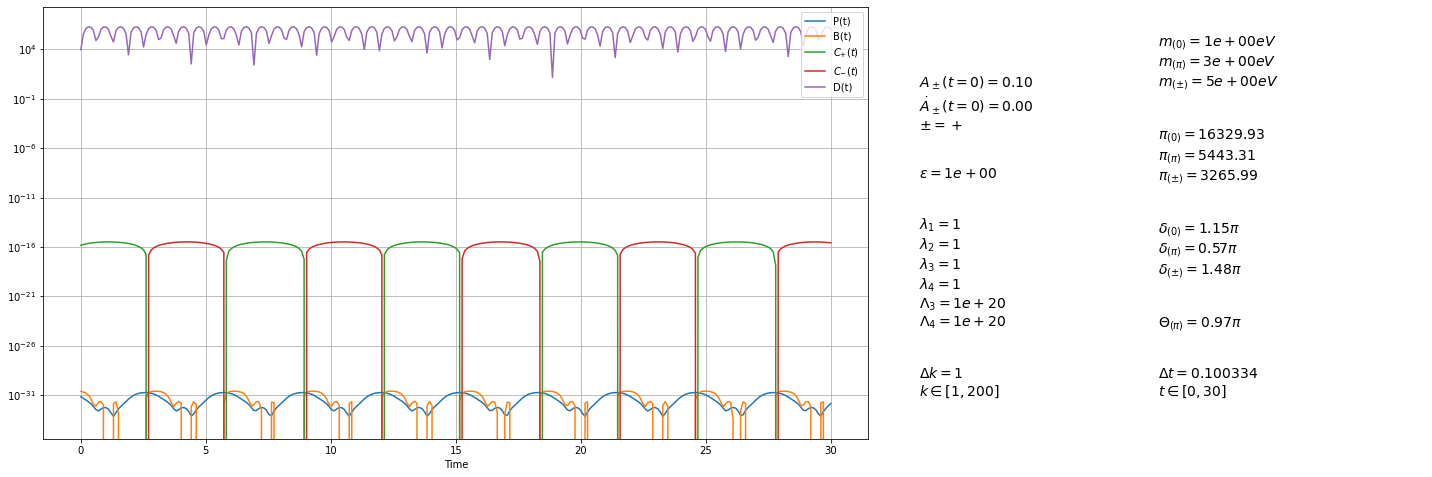

P(t) range: [7.3e-34, 1.9e-31]
B(t) range: [-2.9e-31, 2.6e-31]
C(t) range: [-3.3e-16, 3.3e-16] for + case
C(t) range: [-3.3e-16, 3.3e-16] for - case
D(t) range: [1.4e+01, 1.9e+06]


In [11]:
# Compare model coefficient values over time
plt.figure(figsize = (20,7))
times = t

plt.subplot2grid((2,5), (0,0), colspan=3, rowspan=2)
plt.plot(times, P(times),label="P(t)")
plt.plot(times, B(times),label="B(t)")
plt.plot(times, C(times,+1),label="$C_{%s}(t)$" % signstr[+1])
plt.plot(times, C(times,-1),label="$C_{%s}(t)$" % signstr[-1])
plt.plot(times, D(times),label="D(t)")

plt.xlabel('Time')
plt.yscale('log')
plt.grid()
plt.legend()

textstr1, textstr2 = get_text_params(case='simple')

plt.subplot2grid((2,5), (0,3), rowspan=2)
plt.text(0.15, 0.1, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((2,5), (0,4), rowspan=2)
plt.text(0, 0.1, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

print("P(t) range: [%.1e, %.1e]" % (min(P(times)),max(P(times))))
print("B(t) range: [%.1e, %.1e]" % (min(B(times)),max(B(times))))
print("C(t) range: [%.1e, %.1e] for + case" % (min(C(times, +1)),max(C(times, +1))))
print("C(t) range: [%.1e, %.1e] for - case" % (min(C(times, -1)),max(C(times, -1))))
print("D(t) range: [%.1e, %.1e]" % (min(D(times)),max(D(times))))


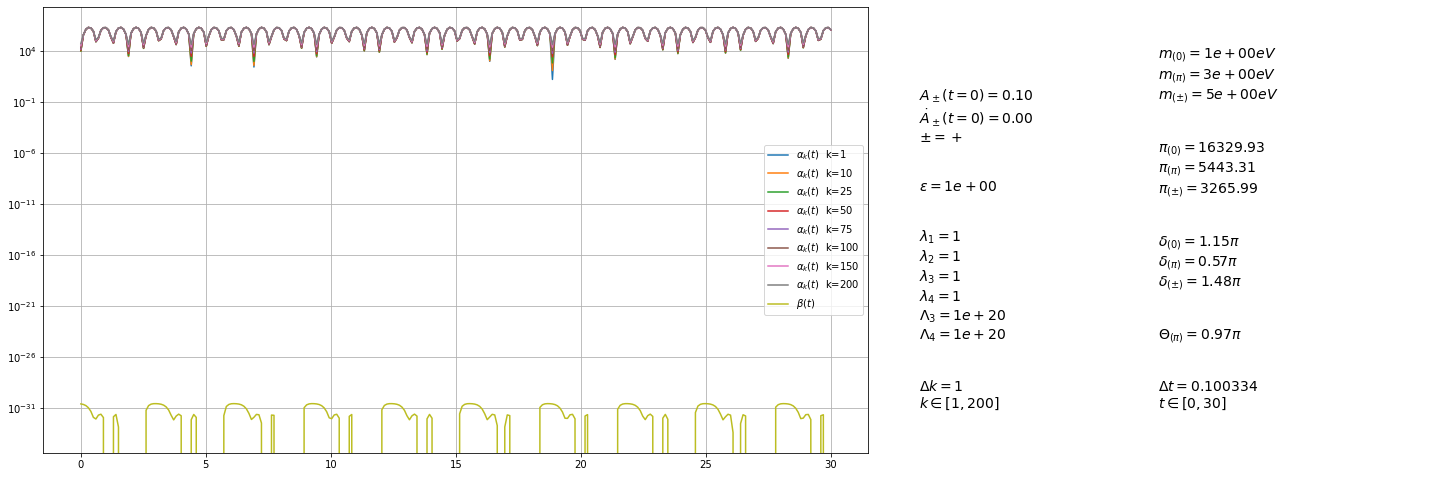

Alpha(t) range: [1.5e+01, 1.9e+06] when k = 1
Alpha(t) range: [1.1e+02, 1.9e+06] when k = 10
Alpha(t) range: [6.4e+02, 1.9e+06] when k = 25
Alpha(t) range: [2.5e+03, 1.9e+06] when k = 50
Alpha(t) range: [5.6e+03, 1.9e+06] when k = 75
Alpha(t) range: [1.0e+04, 1.9e+06] when k = 100
Alpha(t) range: [2.3e+04, 1.9e+06] when k = 150
Alpha(t) range: [4.0e+04, 2.0e+06] when k = 200
Beta(t) range: [-2.9e-31, 2.6e-31]


In [12]:
# Compare Alpha(t) and Beta(t) for a sampling of k values
times = t
Alpha = lambda t, k: (k**2 + C(t, A_pm)*k + D(t)) / (1 + P(t))
Beta = lambda t: B(t) / (1 + P(t))

plt.figure(figsize = (20,7))
plt.subplot2grid((2,5), (0,0), colspan=3, rowspan=2)

#k_samples = np.geomspace(1,len(k_values),num=5)
k_samples = [i for i, k_i in enumerate(k_values) if k_i in [0,1,10,25,50,75,100,150,200]]
for k_sample in k_samples:
    k_s = int(k_sample)
    plt.plot(times, Alpha(times, k_values[k_s]), label=r"$\alpha_k(t)$  k=%d" % k_values[k_s])

plt.plot(times, Beta(times), label=r"$\beta(t)$")

plt.grid()
plt.yscale('log')
plt.legend()

textstr1, textstr2 = get_text_params(case='simple')

plt.subplot2grid((2,5), (0,3), rowspan=2)
plt.text(0.15, 0.1, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((2,5), (0,4), rowspan=2)
plt.text(0, 0.1, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

for k_s in k_samples:
    print("Alpha(t) range: [%.1e, %.1e] when k = %d" % (min(Alpha(times, k_values[k_s])), max(Alpha(times, k_values[k_s])), k_values[k_s]))
print("Beta(t) range: [%.1e, %.1e]" % (min(Beta(times)), max(Beta(times))))

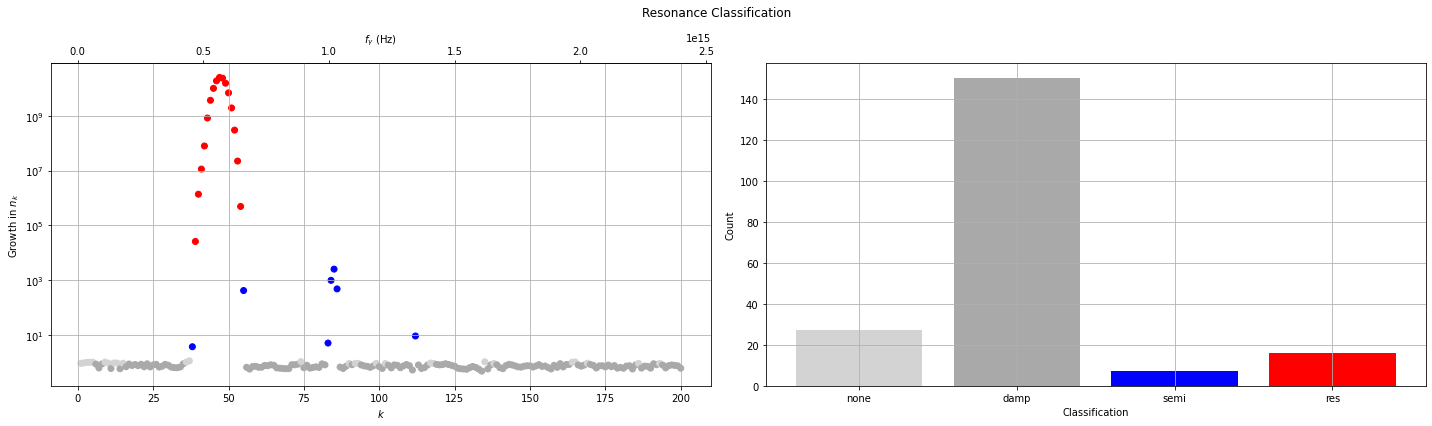

In [13]:
#print(params)

# store max, all-time mean, and late-time mean for each k-mode
params["k_peak_arr"] = k_func(max)
params["k_mean_arr"] = k_func(np.mean)
params["k_sens_arr"] = k_sens(np.mean, t_sens)
params["k_class_arr"] = k_class(np.mean, t_sens, A_sens)

params["class"] = tot_res

#print(params["class"])
#print(params["k_class_arr"])

class_colors = {'none': 'lightgrey', 'damp': 'darkgrey', 'semi': 'blue', 'res': 'red'}
#print(k_class(np.mean, t_sens, A_sens))
#print(k_ratio(np.mean, t_sens, A_sens))

# Resonant k-mode (units of mass = eV) to frequency (Hz) conversion functions
m0 = m[0]
k_to_Hz = lambda kr, m0=m0: 1.2e4 * (kr * m0 / 10e-10)
Hz_to_k = lambda fr, m0=m0: (10e-10 / m0) * (fr / 1.2e4)

plt.figure(figsize = (20,6))
plt.suptitle('Resonance Classification')

ax = plt.subplot2grid((2,4), (0,0), colspan=2, rowspan=2)
plt.scatter(k_values, k_ratio(np.mean, t_sens, A_sens), c=[class_colors[k_c] if k_c in class_colors else 'orange' for k_c in k_class(np.mean, t_sens, A_sens)])
plt.xlabel('$k$')
axT = ax.secondary_xaxis('top', functions=(k_to_Hz, Hz_to_k))
#axT.xaxis.set_minor_locator(AutoMinorLocator())
axT.set_xlabel('$f_{\gamma}$ (Hz)')
plt.ylabel('Growth in $n_k$')
plt.yscale('log')
plt.grid()

plt.subplot2grid((2,4), (0,2), colspan=2, rowspan=2)
#plt.bar(k_values,k_ratio(np.mean, t_sens, A_sens),color=[class_color(k_c) for k_c in k_class(np.mean, t_sens, A_sens)])
class_counts = [(np.array(k_class(np.mean, t_sens, A_sens)) == class_label).sum() for class_label in class_colors.keys()]
plt.bar(class_colors.keys(),class_counts,color=class_colors.values())
plt.xlabel('Classification')
plt.ylabel('Count')
plt.grid()

plt.tight_layout()
plt.show()